# Brain Tumor Detection
---
---

# <a id='env'># Setting up the Environment</a>

In [1]:
import os

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model

C:\Users\taufi\Anaconda3\envs\tf_14\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\taufi\Anaconda3\envs\tf_14\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\taufi\Anaconda3\envs\tf_14\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\taufi\Anaconda3\envs\tf_14\lib\site-packages\tensorflow\python\f

In [4]:
RANDOM_SEED = 123

IMG_SIZE = (224, 224)

NUM_CLASSES = 1

EPOCHS = 50

TRAIN_PATH = os.path.join('dataset_brain_mri_cropped', 'TRAIN')
TEST_PATH = os.path.join('dataset_brain_mri_cropped', 'TEST')
VALID_PATH = os.path.join('dataset_brain_mri_cropped', 'VALID')

# <a id='cnn'># CNN Model</a>

## <a id='aug'>## Data Augmentation</a>

In [5]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [6]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = validation_datagen.flow_from_directory(
    VALID_PATH,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 196 images belonging to 2 classes.
Found 37 images belonging to 2 classes.


## <a id='model'>## Build Model</a>

In [7]:
mobilenet_model = MobileNet(
    weights='imagenet', 
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

for layer in mobilenet_model.layers[:-6]:
    layer.trainable = False

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
x = mobilenet_model.output
x = Flatten()(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='sigmoid')(x)

model = Model(inputs=mobilenet_model.input, outputs=predictions, name='brain_tumor_model_1')

In [9]:
model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
model.summary()

Model: "brain_tumor_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 3

In [11]:
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000002D16EB24708> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x000002D16EB18FC8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002D16EB18108> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x000002D16EB6B8C8> False
<tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x000002D16EB84648> False
<tensorflow.python.keras.layers.convolutional.DepthwiseConv2D object at 0x000002D16EBB9348> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x000002D16EC9C2C8> False
<tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x000002D16ECADEC8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002D16ECBF108> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x000002D16ED82588> False
<tensorflow.python.keras.layers.advanced_activ

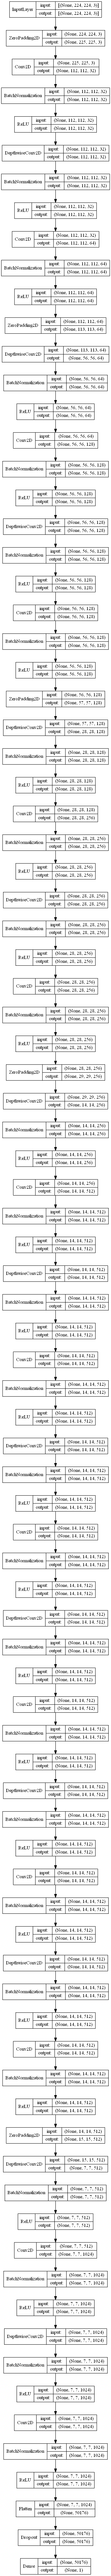

In [12]:
plot_model(
    model,
    to_file=os.path.join('Model', model.name+'.png'),
    show_shapes=True,
    show_layer_names=False
)

In [13]:
myEarlyStopping = EarlyStopping(
    monitor='val_acc', 
    mode='max',
    patience=10
)

myCheckpoint = ModelCheckpoint(
    'Model/brain_tumor_1.h5', 
    monitor='val_acc', 
    save_best_only=True
)

In [14]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[myCheckpoint, myEarlyStopping],
    varbose=2
)

Epoch 1/50
50/50 [==============================] - 26s 515ms/step - loss: 0.9535 - acc: 0.7279 - val_loss: 1.7895 - val_acc: 0.3718
Epoch 2/50
50/50 [==============================] - 18s 352ms/step - loss: 0.4554 - acc: 0.8383 - val_loss: 2.1082 - val_acc: 0.4006
Epoch 3/50
50/50 [==============================] - 19s 384ms/step - loss: 0.3163 - acc: 0.8939 - val_loss: 1.8062 - val_acc: 0.5160
Epoch 4/50
50/50 [==============================] - 19s 384ms/step - loss: 0.3194 - acc: 0.9237 - val_loss: 1.1127 - val_acc: 0.5929
Epoch 5/50
50/50 [==============================] - 17s 343ms/step - loss: 0.2487 - acc: 0.9245 - val_loss: 0.7370 - val_acc: 0.7051
Epoch 6/50
50/50 [==============================] - 17s 344ms/step - loss: 0.1827 - acc: 0.9409 - val_loss: 1.3563 - val_acc: 0.6474
Epoch 7/50
50/50 [==============================] - 18s 350ms/step - loss: 0.1585 - acc: 0.9459 - val_loss: 0.7762 - val_acc: 0.7853
Epoch 8/50
50/50 [==============================] - 17s 338ms/step - 

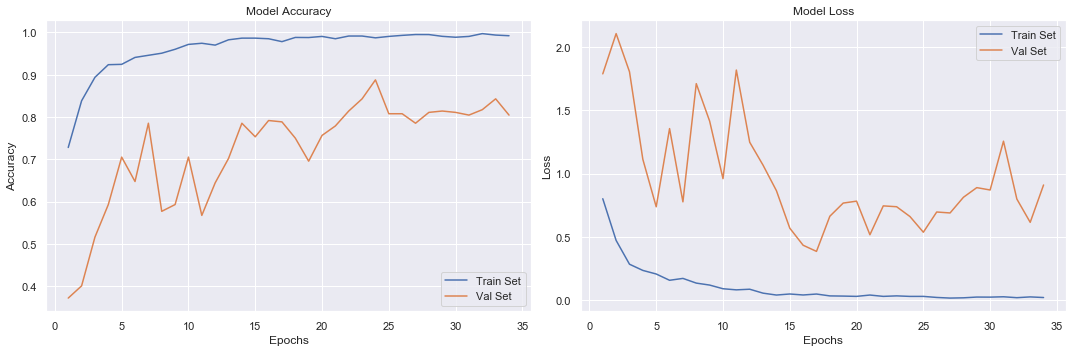

In [15]:
# plot model performance
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()